In [3]:
# First, our import statements.
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as scistat
from functools import partial
from typing import Callable
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import sys
path_to_wkshop = '/home1/jrudoler/CMLWorkshop/'# change this if necessary!
sys.path.append(path_to_wkshop)
from CMLLoad import CMLLoad
#from common import progress_bar

### Exercises

In [40]:
# Remember to update this to where your CMLExamples data is located.
load = CMLLoad('../CMLExamples')

# We load the dataframe for all sessions.
df = load.Index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# Pick the first session
df_sess = df_select.iloc[0]

# For first session...
evs = load.Load(df_sess, 'events')
word_evs = evs[evs['type']=='WORD']

#loading all bipolar pairs, but use 'contacts' for non-rereferenced data
channels = load.Load(df_sess, 'channels')

eeg, samplingrate, channels = load.LoadEEG(df_sess, ev_start=0, ev_len=1600)

**Exercise: Plot the distributions of 'ind' x, y, and z values for all of R1111Ms electrodes.**

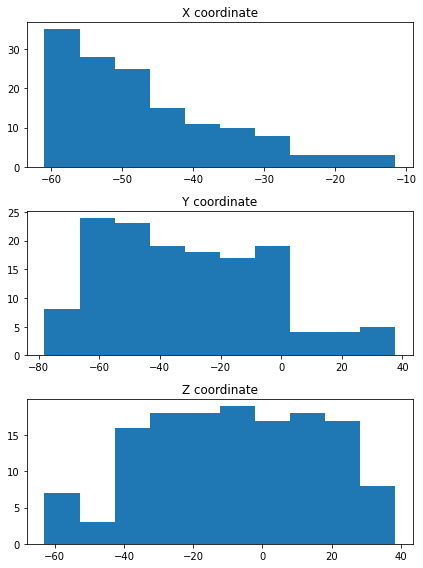

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8))
ax[0].hist(channels['ind.x'])
ax[0].set_title('X coordinate')
ax[1].hist(channels['ind.y'])
ax[1].set_title('Y coordinate')
ax[2].hist(channels['ind.z'])
ax[2].set_title('Z coordinate')
plt.tight_layout()

**Exercise: How many electrodes does R1111M have placed in the temporal cortex? How many on the left and how many on the right?**

We can inspect the channels dataframe and notice that electrodes on the left side of the brain have labels starting with "L" and also have negative x positions.

In [56]:
channels['ind.region'].str.contains('temporal').sum()

50

In [57]:
right_temp = np.sum((channels['ind.x'] > 0) & (channels['ind.region'].str.contains('temporal')))
left_temp = np.sum((channels['ind.x'] < 0) & (channels['ind.region'].str.contains('temporal')))
print(right_temp, 'on the right side')
print(left_temp, 'on the left side')

0 on the right side
50 on the left side


**Exercise: Plot the ERP in a 2-second span surrounding the recall of each word event for a lateral occipital electrode from the first FR1 session conducted by R1383J. Does our occipital electrode show an effect? What about elsewhere in the brain?**

Text(0, 0.5, 'Z-scored Voltage')

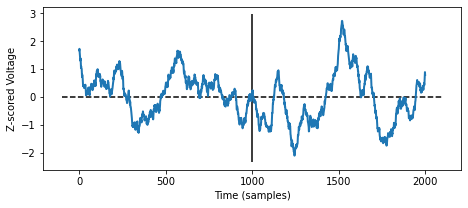

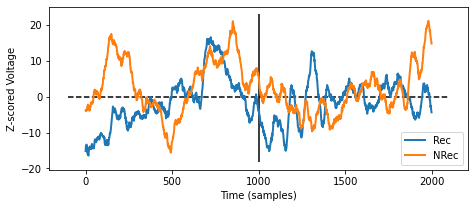

In [31]:
df_subexp = df[(df['subject']=='R1383J') & (df['experiment']=='FR1')]
df_sess = df_subexp.iloc[0]

evs = load.Load(df_sess, 'events')
wordrec_evs = evs[evs['type']=='REC_WORD']

#Load the EEG for encoding events
# rel_start and rel_stop unit is milliseconds.
eeg, samplerate, channels = load.LoadEEG(df_sess, -1000, 2000)
mid_occ = np.argwhere(['middle occipital' in str(c) for c in channels['mni.region']]).ravel()
elec = mid_occ[0]
eeg = eeg[wordrec_evs.index, elec:(elec+1)]

#Get recalled/not recalled status
rec_status = wordrec_evs['recalled']

mu = np.mean(np.mean(eeg[:, 0, :], 1), 0)
std_ = np.std(np.mean(eeg[:, 0, :], 1), 0)

zeeg = (eeg-mu)/std_

sr = samplerate
midpoint_seconds = 1

#Plot the trace averaged across all events
plt.figure(figsize=(7.5, 3)); ax=plt.subplot(111)
plt.plot(np.mean(zeeg[:, 0, :], 0), linewidth=2,)
plt.vlines([midpoint_seconds*sr], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)'); plt.ylabel('Z-scored Voltage')

#Plot the trace for rec/nrec separately
plt.figure(figsize=(7.5, 3)); ax=plt.subplot(111)
plt.plot(np.mean(zeeg[rec_status, 0, :], 0), linewidth=2, label='Rec')
plt.plot(np.mean(zeeg[~rec_status, 0, :], 0), linewidth=2, label='NRec')
plt.vlines([midpoint_seconds*sr], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.legend()
plt.xlabel('Time (samples)'); plt.ylabel('Z-scored Voltage')

# Assignment 3

In [58]:
# These user-defined functions are used below. They're really part of the solution, but defining them this way 
# makes the solutions below cleaner and more organized (and more readable)
def confidence_interval(data, confidence=0.95, axis=0):
    n = data.shape[axis]
    m, se = np.mean(data, axis=axis), (np.std(data, axis=axis, ddof=1) / np.sqrt(n))
    h = se * scistat.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def multiindex_to_array(multiindex):
    new_index = pd.MultiIndex.from_product(multiindex.index.levels)
    multiindex = multiindex.reindex(new_index).fillna(np.nan)
    
    levels = [len(l) for l in multiindex.index.levels]
    return multiindex.values.reshape(*levels)

#@progress_bar()
def apply_to_index(index, analyses, preload=False, eeg_args={}):
    ''' 
    Function to apply an analysis function to all rows of a CMLLoad Index.
        
        Args:
            analysis: Dictionary of callables that take either an index row or
                      loaded events, eeg, and eeg loading arguments.
            preload: Boolean for whether functions should take an index row or
                     preloaded events, eeg data, and eeg_args.
            eeg_args: Dictionary of args to pass to LoadEEG and analysis if preloading
        Returns:
            DataFrame with subject and sessions columns added to dataframes returned
            by analysis function, labelled with keys.
    '''
    results = []
    
    #i = 0
    for subject in index.subject.unique():
        for session in index.query("subject == @subject")['session'].unique():
            #i += 1
            #yield i / len(index)
            
            index_row = index.query("subject == @subject \
                                     and session == @session").iloc[0]
            
            if preload:
                try:
                    eeg_tuple = load.LoadEEG(index_row, **eeg_args)
                    events = load.Load(index_row, "events")
                except:
                    print(f"Error loading data for {subject} : {index_row['experiment']} : {session}")
                    continue
                
            for label, an in analyses.items():
                if preload:
                    result = an(events, eeg_tuple, eeg_args)
                else:
                    result = an(index_row)
                    
                if result is None:
                    continue

                result["subject"] = subject
                result["session"] = session
                result["label"] = label

                results.append(result)
    return pd.concat(results, ignore_index=True)

In [2]:
# The CMLLoad class is your gateway to the experimental data, including channels, events, and eeg data.
from CMLLoad import CMLLoad

# We need to tell CMLLoad what directory contains the experimental data files.
# Point this to where they are on your system.
load = CMLLoad('./CMLExamples')
df = load.Index()
ltpFR2_subs = df.query("experiment == 'ltpFR2'")


### Question 1

We found some pretty significant artifacts when plotting raw voltages. We could track down the individual sessions that had these challenges, but z scoring against all voltages in a session effectively minimizes the impact of such extreme outliers for the purposes of computing a preliminary erp. A more prinicipled approach would be to discard data using a threshold on maximum amplitude, std deviation, or other statistical measure of the variance in a signal. Please also note that this first approach uses bootstrapping to calculate our confidence interval. We include this for demonstration, though bootstrapping is really not valid when using such a small number of observations (subjects).

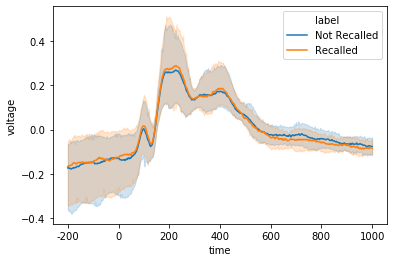

In [3]:
def erp(events, eeg_tuple, eeg_args, events_filter=lambda x: x):
    events = events_filter(events)
    eeg, sampling_rate, channels = eeg_tuple    
    eeg = eeg[events.index, channels['label'] == 'E75', :]
    
    # baseline correct, assuming that ev_start < 0
    eeg = eeg - np.mean(eeg[:, :-sampling_rate*eeg_args["ev_start"] // 1000], axis=1)[:, None]

    # data is rather noisy, we'll z score all voltages against the recorded events.
    mean = np.mean(eeg)
    std = np.std(eeg)
    #eeg = eeg[np.abs(np.mean(eeg, axis=1)) < mean + 4*std, :]
    eeg = (eeg - mean) / std
    
    # ^ numpy arrays for speed of calculation    # Moving between the two is
    #                                            # straightforward, so we can
    # v pandas dataframes for ease of plotting   # pick the best for a given task.
    
    session_erp = np.mean(eeg, axis=0)
    timestamps  = np.linspace(eeg_args["ev_start"],
                              eeg_args["ev_start"] + eeg_args["ev_len"], 
                              session_erp.shape[0]) 
    
    # requires numpy >= 1.17
    #timestamps  = pd.timedelta_range(start=eeg_args["ev_start"], 
    #                                 end=eeg_args["ev_start"] + eeg_args["ev_len"], 
    #                                 periods=session_erp.shape[0])
    
    return pd.DataFrame({"voltage":session_erp, "time":timestamps})

analyses = {"Recalled": partial(erp, events_filter=lambda evs: evs.query("type == 'WORD' \
                                                                          and recalled == True")),
            
            "Not Recalled": partial(erp, events_filter=lambda evs: evs.query("type == 'WORD' \
                                                                              and recalled == False"))}

eeg_args = {"ev_start": -200, "ev_len": 1200}

erp_data = apply_to_index(ltpFR2_subs, analyses, preload=True, eeg_args=eeg_args)
erp_data = erp_data.groupby(["subject", "time", "label"]).mean().reset_index()
ax = sns.lineplot(x="time", y="voltage", hue='label', data=erp_data)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

### Questions 2, 3, and 4

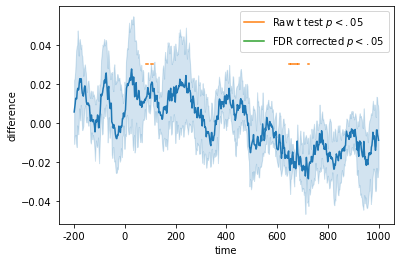

In [4]:
diff_erp = erp_data.pivot_table(index=["subject", "time"], 
                                columns="label", 
                                values=["voltage"])

# rename columns to Recalled and Not Recalled, rather than multiindex
diff_erp.columns = diff_erp.columns.get_level_values(1)

diff_erp["difference"] = diff_erp["Recalled"] - diff_erp["Not Recalled"]

# It is possible to do the t tests without changing to a numpy array
# using a different pivot operation, but it really doesn't make sense
# for timeseries data imo. Pandas excel when we can deal with rows or
# columns and struggle when we want to compare multiple dimensions.

subject_by_time = diff_erp.pivot_table(index=["subject"], 
                                       values=["Recalled", 
                                               "Not Recalled"], 
                                       columns="time")

rec_mat = subject_by_time[("Recalled",)].to_numpy()

nrec_mat = subject_by_time[ ("Not Recalled",)].to_numpy()


_, raw_p = scistat.ttest_rel(rec_mat, nrec_mat, axis=0)
_, fdr_p  = fdrcorrection(raw_p)

times = sorted(diff_erp.reset_index()["time"].unique())

raw_p = np.where(raw_p < .05, 1, np.nan)*.03
fdr_p = np.where(fdr_p < .05, 1, np.nan)*.035

ax = sns.lineplot(x="time", y="difference", data=diff_erp.reset_index())
ax.plot(times, raw_p, label="Raw t test $p<.05$")
ax.plot(times, fdr_p, label="FDR corrected $p<.05$")
#ax.set(ylim=(-.05, .05))
ax.legend()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

## Alternative Approach

In my solution above, I stored and manipulated all of my data in pandas dataframes. Many people work with data in 
an array format instead, where arrays have a shape something like [condition, subject, session, time]. This makes
many multi-dimensional operations easier but sacrifices some flexibility and the strong plotting support seaborn has
for dataframes. Both are viable, though the method below is a bit more common. Please note again that we are calculating
the confidence interval analytically, leading to a different result than above. With larger numbers of subjects, these
two approaches should converge to similar values.

ERP matrix shape:  (2, 4, 24, 600)


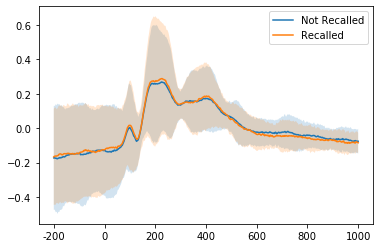

In [5]:
# create numpy arrays and just work with those. My code assumes I'm working
# mostly in pandas, so I have a roundabout way of getting there. You can
# directly create a numpy array with shape [condition, subject, session, time]
# and skip through this first bit. 

erp_data = apply_to_index(ltpFR2_subs, analyses, preload=True, eeg_args=eeg_args)
# this function fills in any missing sessions with nan values
erp_mat = multiindex_to_array(erp_data.set_index(["label", 
                                                  "subject", 
                                                  "session", 
                                                  "time"]))
print("ERP matrix shape: ", erp_mat.shape)

# unpack first dimension into named variables, with shape [subject, session, time]
nrecmat, recmat = erp_mat

# I had previously computed times, you may just as easily re-calculate or
# use times from another source
times = sorted(erp_data["time"].unique())

# average over session and compute analytic confidence intervals over subjects
mean, low, high = confidence_interval(np.nanmean(nrecmat, axis=1), axis=0)
ax = sns.lineplot(x=times, y=mean, label="Not Recalled")
ax.fill_between(times, low, high, alpha=.2)

mean, low, high = confidence_interval(np.nanmean(recmat, axis=1), axis=0)
ax = sns.lineplot(x=times, y=mean, label="Recalled", ax=ax)
ax.fill_between(times, low, high, alpha=.2)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

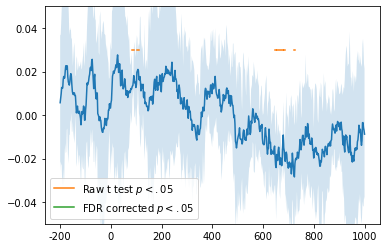

In [6]:
diff_recmat = recmat - nrecmat
mean, low, high = confidence_interval(np.nanmean(diff_recmat, axis=1), axis=0)

_, raw_p = scistat.ttest_rel(np.nanmean(recmat, axis=1), 
                             np.nanmean(nrecmat, axis=1), 
                             axis=0)

_, fdr_p  = fdrcorrection(raw_p)

times = sorted(erp_data["time"].unique())

raw_p = np.where(raw_p < .05, 1, np.nan)*.03
fdr_p = np.where(fdr_p < .05, 1, np.nan)*.035

ax = sns.lineplot(x=times, y=mean, data=diff_erp)
ax.fill_between(times, low, high, alpha=.2)
ax.plot(times, raw_p, label="Raw t test $p<.05$")
ax.plot(times, fdr_p, label="FDR corrected $p<.05$")
ax.set(ylim=(-.05, .05))
ax.legend()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))